In [1]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [2]:
def getrealconc(t,x,y,D):
    blobcentre = np.array([t+10,t+20]) #1m/s
    blobsize = np.sqrt(2*2*D*(t+1))
    d = np.linalg.norm(np.array([x,y])-blobcentre)
    #v = d
    v = 300*norm(0,blobsize).pdf(d)
    return [t,t+10,x,y],v

In [3]:
X = []
Y = []
D = 2.0
for x in np.linspace(30,100,10):
    for y in np.linspace(30,100,10):
        for t in np.linspace(0,60,5):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

C:\Users\chris\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


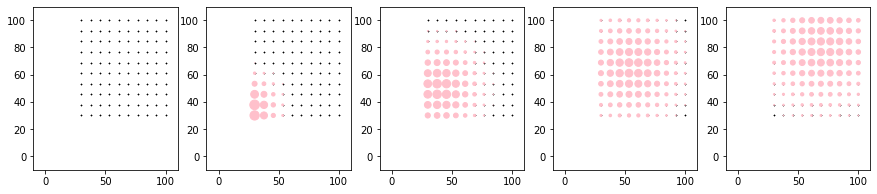

In [4]:
plt.figure(figsize=[15,3])
for i,t in enumerate(np.linspace(0,60,5)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')

In [5]:
boundary = proposeboundary(X)
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10
print(boundary)

([-7.0, -10, -10], [77.0, 107.0, 107.0])


In [6]:
#set up our model...
N_feat = 2000 #Number of features used to infer the source
k = EQ(20, 4)
res = [300,50,50]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
noiseSD = 0.02
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(1,1)
k_0 = 0.05
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference

#maybe this is the sort of equivalent to the number of upcrossings in 3d?
#the number of fourier features is going to need to be of this order presumably?
np.prod(np.array(boundary[1])-np.array(boundary[0]))/(k.l2*np.pi)

<ipython-input-6-b931d4e04ed3>:5: RuntimeWarning: overflow encountered in long_scalars
  gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)


array([18300.84493427, 18300.84493427, 18300.84493427])

In [7]:
mInfer.computeModelRegressors(Nparticles=20,compact=True) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done


In [8]:
Nsamps = 3
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z,compact=True) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)

cache miss, computing source from phi...
Computing Source from Phi...
cache miss, computing source from phi...
Computing Source from Phi...
cache miss, computing source from phi...
Computing Source from Phi...


In [9]:
#scaleby = [50,2,2]
#mInfer.coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]] #20x10x10
concmean,concvar,conc = mInfer.computeConcentration(meanZ,covZ,Nsamps=1,Nparticles=10,interpolateSource=True)

Initialising particles...
Particle shape:
(10, 300, 50, 50, 3)
Diffusing particles...
cache miss, computing source from phi...
Computing Source from Phi...


In [10]:
#plt.imshow(concmean_noint[5,:,:])
#plt.colorbar()
#plt.clim([-10,10])

In [11]:
#plt.imshow(concmean[5,:,:])
#plt.colorbar()
#plt.clim([-10,10])

In [12]:
gridps = mInfer.coords.transpose([1,2,3,0]).copy()
scaleby = [2,2,2]
gridps = gridps[::scaleby[0],::scaleby[1],::scaleby[2]]
realconc = np.zeros(gridps.shape[:-1])

for i in np.ndindex(gridps.shape[:3]):
    if (i[1]==0) & (i[2]==0): print("%d of %d" % (i[0],gridps.shape[0]))
    _,v= getrealconc(gridps[i][0],gridps[i][1],gridps[i][2],D)
    realconc[i]=v

0 of 150


<ipython-input-2-e1e8ba8847d1>:3: RuntimeWarning: invalid value encountered in sqrt
  blobsize = np.sqrt(2*2*D*(t+1))


1 of 150
2 of 150
3 of 150
4 of 150
5 of 150
6 of 150
7 of 150
8 of 150
9 of 150
10 of 150
11 of 150
12 of 150
13 of 150
14 of 150
15 of 150
16 of 150
17 of 150
18 of 150
19 of 150
20 of 150
21 of 150
22 of 150
23 of 150
24 of 150
25 of 150
26 of 150
27 of 150
28 of 150
29 of 150
30 of 150
31 of 150
32 of 150
33 of 150
34 of 150
35 of 150
36 of 150
37 of 150
38 of 150
39 of 150
40 of 150
41 of 150
42 of 150
43 of 150
44 of 150
45 of 150
46 of 150
47 of 150
48 of 150
49 of 150
50 of 150
51 of 150
52 of 150
53 of 150
54 of 150
55 of 150
56 of 150
57 of 150
58 of 150
59 of 150
60 of 150
61 of 150
62 of 150
63 of 150
64 of 150
65 of 150
66 of 150
67 of 150
68 of 150
69 of 150
70 of 150
71 of 150
72 of 150
73 of 150
74 of 150
75 of 150
76 of 150
77 of 150
78 of 150
79 of 150
80 of 150
81 of 150
82 of 150
83 of 150
84 of 150
85 of 150
86 of 150
87 of 150
88 of 150
89 of 150
90 of 150
91 of 150
92 of 150
93 of 150
94 of 150
95 of 150
96 of 150
97 of 150
98 of 150
99 of 150
100 of 150
101 of 1

NameError: name 'tempgridX' is not defined

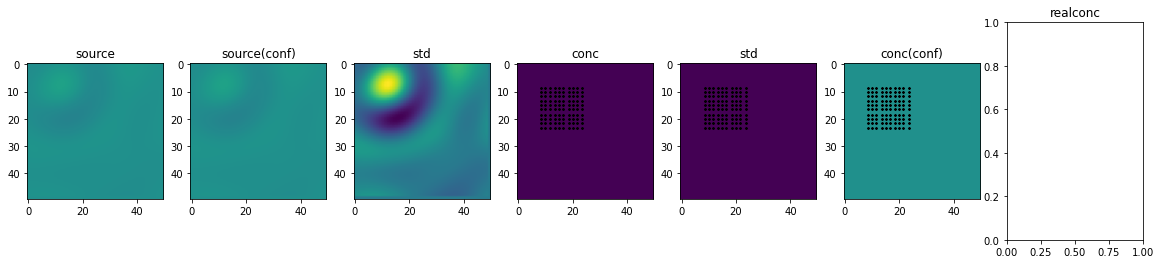

In [13]:
gridX = mInfer.getGridCoord(X[:,1:])/np.array(scaleby)

for tsamp in range(0,mInfer.coords.shape[1],1):
    plt.figure(figsize=[20,4])
    
    plt.subplot(1,7,1)
    if tsamp==0: plt.title('source')
    plt.imshow(sourcemean[tsamp,:,:])
    plt.clim([-1,1])
    
    plt.subplot(1,7,2)  
    if tsamp==0: plt.title('source(conf)')
    plt.imshow(sourcemean[tsamp,:,:])
    plt.clim([-1,1])    
    
    plt.subplot(1,7,3)
    if tsamp==0: plt.title('std')
    vals = sourcemean[tsamp,:,:]
    alphas = np.sqrt(sourcevar[tsamp,:,:])<0.05
    plt.imshow(vals,alpha=alphas.astype(float))
    
    plt.subplot(1,7,4)
    if tsamp==0: plt.title('conc')
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(concmean[tsamp,:,:])
    #plt.clim([-5,5])
    #plt.colorbar()
    
    plt.subplot(1,7,5)
    if tsamp==0: plt.title('std')
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(np.sqrt(concvar[tsamp,:,:]))
    #plt.clim([0,0.25])
    #plt.colorbar()
    
    plt.subplot(1,7,6)
    if tsamp==0: plt.title('conc(conf)')
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    vals = concmean[tsamp,:,:]
    alphas = np.sqrt(concvar[tsamp,:,:])<0.05
    plt.imshow(vals,alpha=alphas.astype(float))
    plt.clim([-10,10])
    #plt.clim([-5,5])
    
    plt.subplot(1,7,7)
    if tsamp==0: plt.title('realconc')
    plt.scatter(tempgridX[:,1],tempgridX[:,2],1,color='black')
    plt.imshow(realconc[tsamp//scaleby[0],:,:])    
    plt.clim([-10,10])
    #plt.colorbar()
    
    #t = ts[tsamp*10]
    #plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*5,color='red')
    #